In [1]:
!pip install eli5

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

# Loading data

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *


## use this for holdout 25/75 >>>>>>>>>>>>>>>.
train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

#train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
#test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

train_sampled_all = glob.glob('C:/Users/Asus/Desktop/colab/train_sampled_all_220.csv')
test_unsampled_all = glob.glob('C:/Users/Asus/Desktop/colab/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# # use this for leave patients >>>>>>>>>>>>>>>.

# train_values = np.empty(shape=[0, 222])
# test_values = np.empty(shape=[0, 222])

# train_patients = glob.glob('./drive/MyDrive/compsci/train_patients.csv')
# test_patients = glob.glob('./drive/MyDrive/compsci/test_patients.csv')

# for j in train_patients:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     train_values = np.append(train_values, csvrows, axis=0)

# for j in test_patients:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)
    
# print(train_values.shape)
# print(test_values.shape)

Loading  C:/Users/Asus/Desktop/colab/train_sampled_all_220.csv
Loading  C:/Users/Asus/Desktop/colab/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


# Labeling and preparing data

In [4]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [5]:
# use this for all data training and testing

X_train1 = X_train.reshape(X_train.shape + (1,1))
X_test1 = X_test.reshape(X_test.shape + (1,1))

y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

In [6]:
# #use this for per class testing

# class_num = 8

# N_train = train_values
# N_test = test_values[test_values[:,-2]==class_num]

# X_train = N_train[:,:-2]
# X_test = N_test[:,:-2]

# y_train = N_train[:len(N_train),-2]
# y_test = N_test[:len(N_test),-2]

# # y_train = train_values[:len(N_train),-2]
# # y_test = test_values[:len(N_test),-2]

# X_train1 = X_train.reshape(X_train.shape + (1,1,))
# X_test1 = X_test.reshape(X_test.shape + (1,1,))

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)

In [7]:
#Use this for noisy test data
# r = np.random.normal(0, 1, X_train.shape)
# noise_train = X_train+r
# print(noise_train.shape)
# X_train1 = noise_train.reshape(noise_train.shape + (1,1))

# s = np.random.normal(0, 0.25, X_test.shape)
# noise_test = X_test+s
# print(noise_test.shape)
# X_test1 = noise_test.reshape(noise_test.shape + (1,1))

# function for performance

In [8]:
def showResults(test, pred,model_name):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score=f1_score(test, pred, average='macro') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    print(cm)
    return (model_name,round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

In [9]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 256
activationFunction='relu'

def getlstmModel():
    
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train1.shape[1],1)))
    lstmmodel.add(LSTM(9, return_sequences=True))
    lstmmodel.add(MaxPooling1D(pool_size=2))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(512, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 220, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 220, 9)            4968      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 9)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 990)               0         
                                                                 
 dense (Dense)               (None, 512)               507392    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

# Training our LSTM model

In [10]:
lstmmodelhistory= lstmmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25529/25529 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.8142

C:\Users\Asus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


25529/25529 [==============================] - 121s 5ms/sample - loss: 0.5957 - accuracy: 0.8142 - val_loss: 0.2171 - val_accuracy: 0.9350
Epoch 2/5
25529/25529 [==============================] - 149s 6ms/sample - loss: 0.1778 - accuracy: 0.9439 - val_loss: 0.1747 - val_accuracy: 0.9409
Epoch 3/5
25529/25529 [==============================] - 152s 6ms/sample - loss: 0.1177 - accuracy: 0.9630 - val_loss: 0.1167 - val_accuracy: 0.9638
Epoch 4/5
25529/25529 [==============================] - 162s 6ms/sample - loss: 0.0875 - accuracy: 0.9703 - val_loss: 0.1188 - val_accuracy: 0.9627
Epoch 5/5
25529/25529 [==============================] - 164s 6ms/sample - loss: 0.0722 - accuracy: 0.9759 - val_loss: 0.0896 - val_accuracy: 0.9731


In [11]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[1].output])
last_lstm_lstm = get_last_lstm([X_test1[:,:,:,0]])[0]

get_softmax1_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[-1].output])
softmax1_lstm = get_softmax1_lstm(([X_test1[:,:,:,0]]))[0]
softmax_weight1_lstm = lstmmodel.get_weights()[-1]
softmax_weight_lstm = np.reshape(softmax_weight1_lstm,(9,1))

CAM = np.dot(last_lstm_lstm, softmax_weight_lstm)

# for k in range(5):
#     CAM_lstm = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
#     c = np.exp(CAM_lstm) / np.sum(np.exp(CAM_lstm), axis=1, keepdims=True)
#     plt.figure(figsize=(18, 4))
#     plt.plot(X_test1[k].squeeze())
#     plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
#     # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.clim(0.003,0.010)
#     plt.colorbar()
# plt.show

# Using our model on test data


In [12]:
lstmpredictions = lstmmodel.predict(X_test1[:,:,:,0], verbose=1)

C:\Users\Asus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# Performance metrics and confusion matrix


Accuracy  : 0.928927977180889
Precision : 0.7454957163184797
Recall : 0.9541510618253171
f1score : 0.8027767730180636
[[26235    92   163   393   808   893   113     6]
 [    2  1655     0     1     1     0     1     0]
 [    4     0  2476    10    10     0     0     0]
 [   16     4     1  1127    11    34     6     0]
 [   51     0     7     4   708     1     2     0]
 [    6     1     1     5     0   180     0     0]
 [    7     0     0     4     3     0   408     6]
 [    0     1     0     4     0     0    19  2383]]
              precision    recall  f1-score   support

           1      0.997     0.914     0.954     28703
           2      0.944     0.997     0.970      1660
           3      0.935     0.990     0.962      2500
           4      0.728     0.940     0.821      1199
           5      0.459     0.916     0.612       773
           6      0.162     0.933     0.277       193
           7      0.743     0.953     0.835       428
           8      0.995     0.990     0.

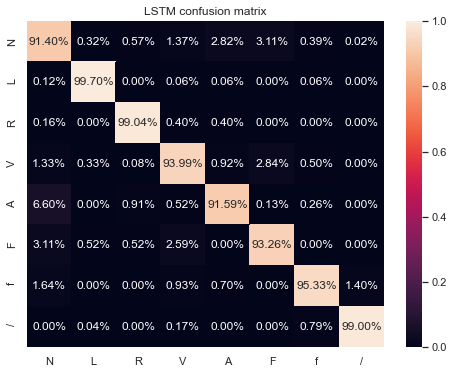

In [13]:
# performance metrics

lstm_predict=np.argmax(lstmpredictions,axis=1)
lstm_actual_value=np.argmax(y_test1,axis=1)
lstm_results = showResults(lstm_actual_value, lstm_predict,'LSTM')
from sklearn import metrics
lstmmetrics = metrics.classification_report(lstm_actual_value, lstm_predict, digits=3)
print(lstmmetrics, 'lstm metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
lstm_cf_m = lstm_results[5].astype('float')/ lstm_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(lstm_cf_m,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('LSTM confusion matrix')
plt.show()

# Interpretability 

In [14]:
from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_lstm_lstm
new_last_lstm = []
for i in range(len(last_lstm_lstm)):
  means = list(means_of_slices(a[i], 20))
  new_last_lstm.append(means)
new_last_lstm = np.array(new_last_lstm)
print(new_last_lstm.shape)

final_last_lstm = []
for i in new_last_lstm:
  final_last_lstm.append(np.repeat(i,20))
final_last_lstm = np.array(final_last_lstm)
print(final_last_lstm.shape)

(37863, 11)
(37863, 220)


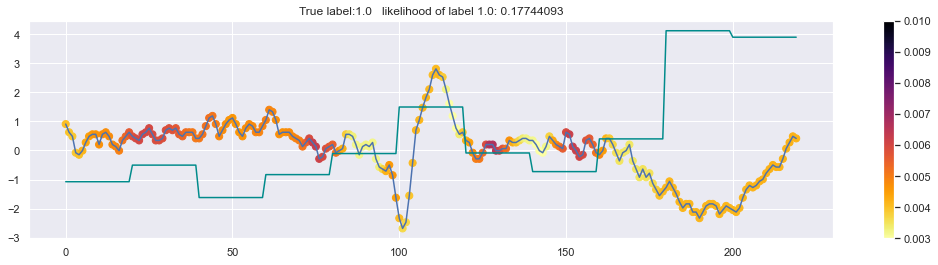

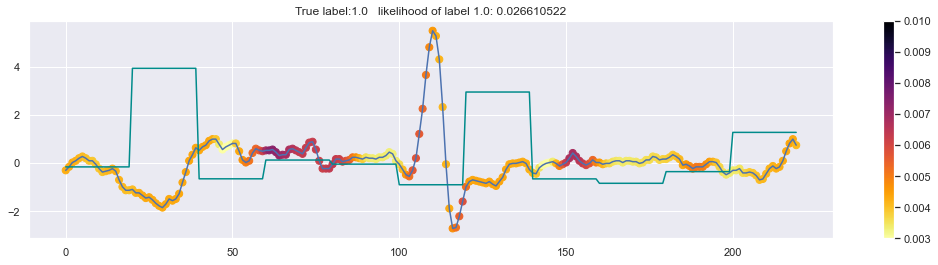

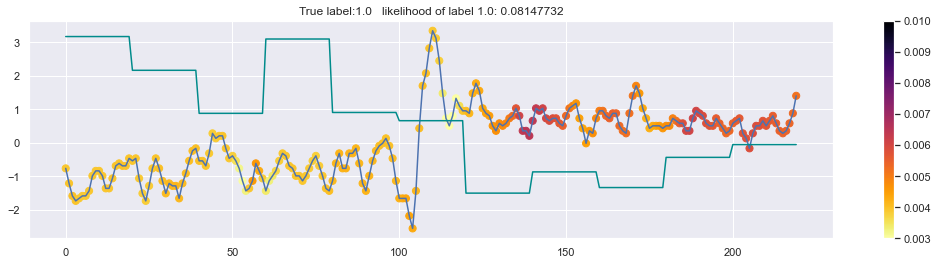

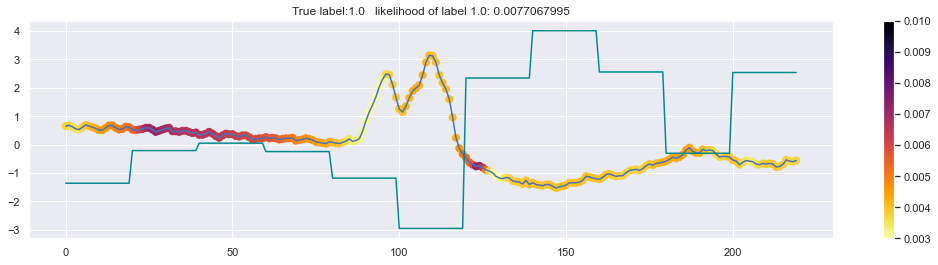

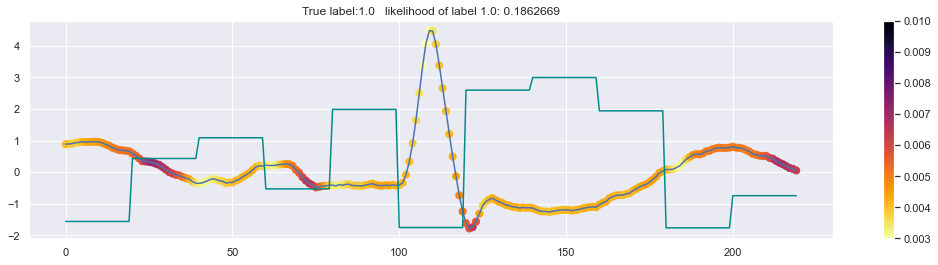

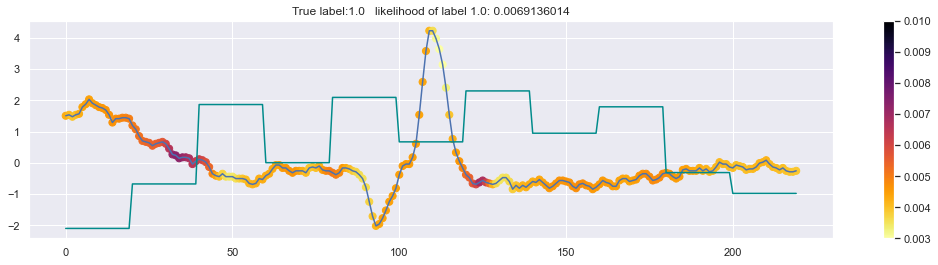

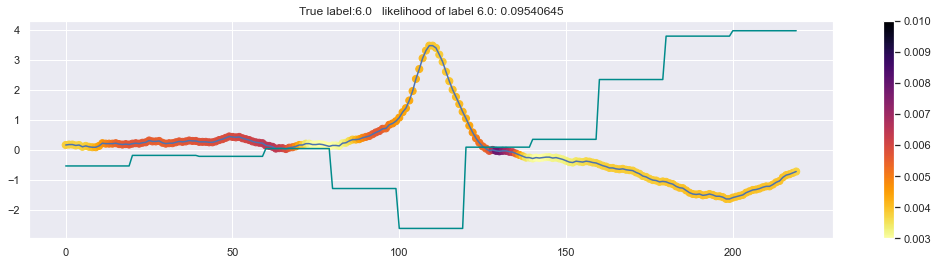

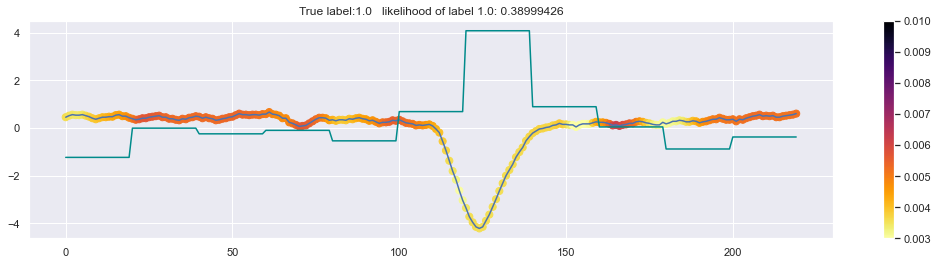

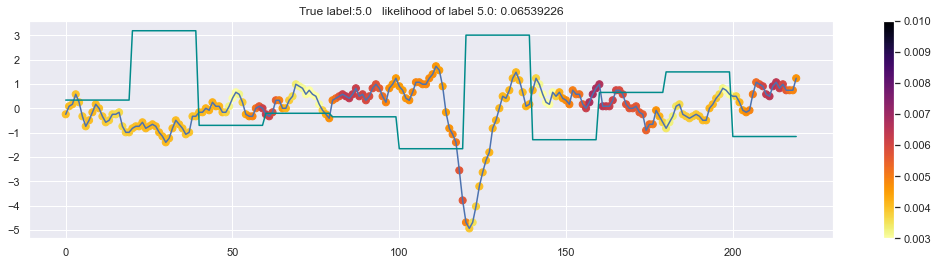

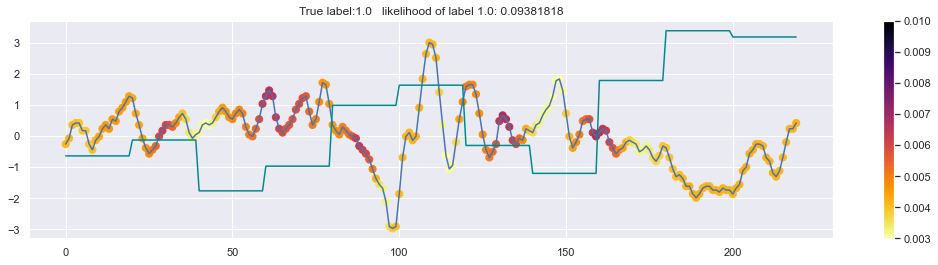

In [15]:
#misclassified saliency
misclass_lstm = np.where(lstm_predict!=lstm_actual_value)
misclass_lstm = misclass_lstm[0].tolist()

for i in misclass_lstm[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

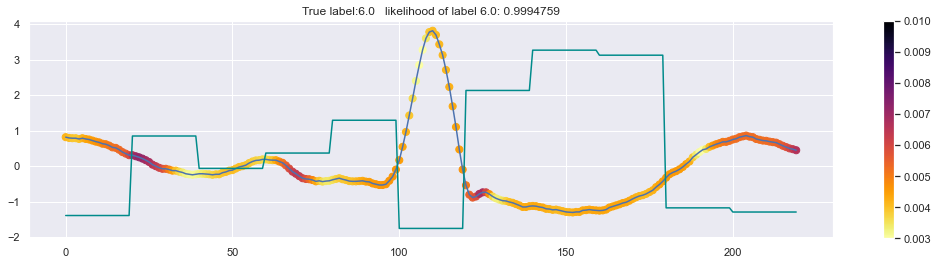

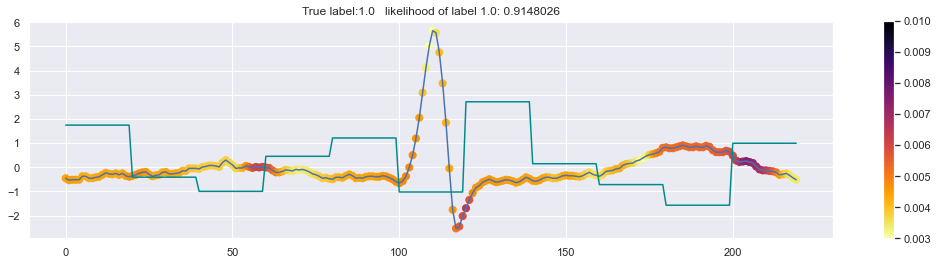

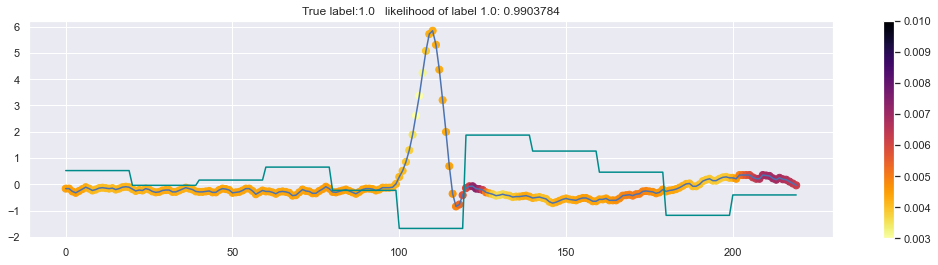

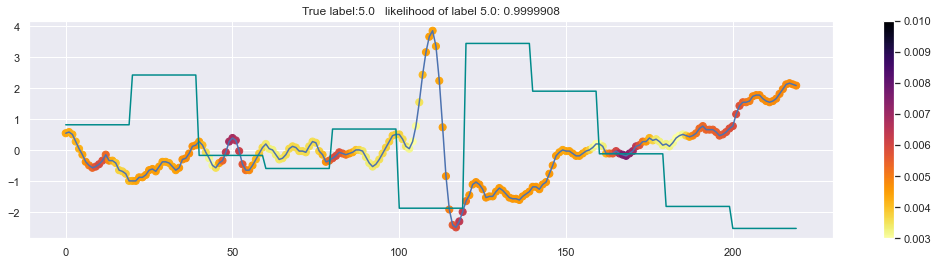

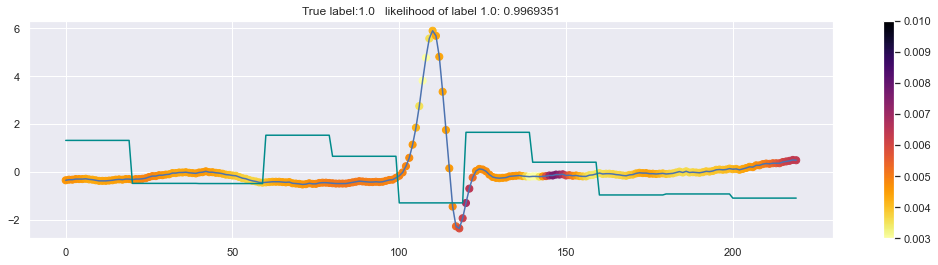

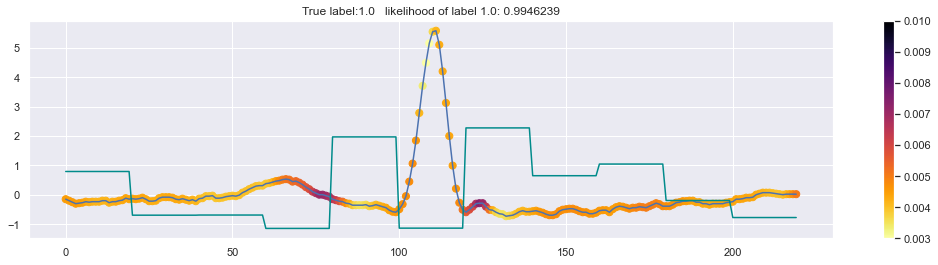

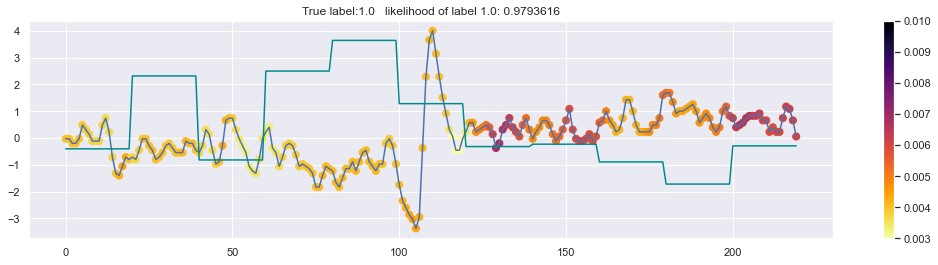

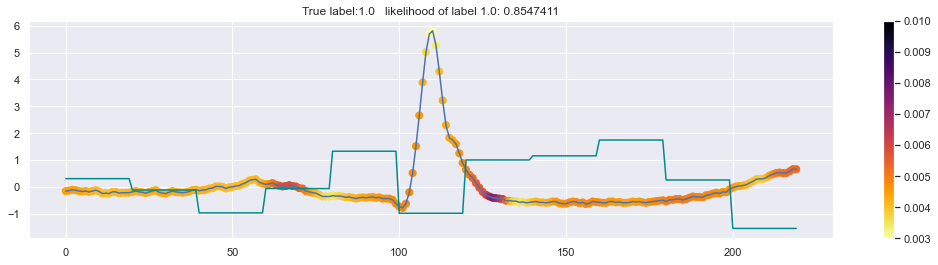

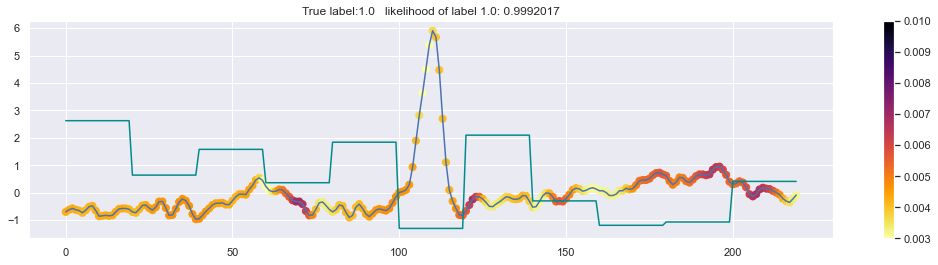

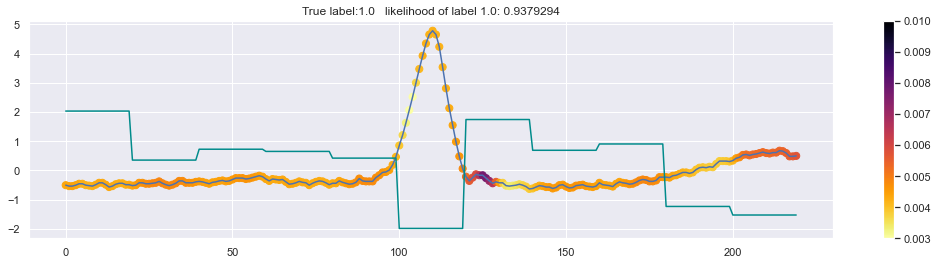

In [16]:
#correct saliency
correct_lstm = np.where(lstm_predict==lstm_actual_value)
correct_lstm = correct_lstm[0].tolist()

for i in correct_lstm[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

In [17]:
# import eli5
# from eli5.sklearn import PermutationImportance
# from sklearn.neural_network import MLPClassifier

# NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
# NNMLP_clf.fit(new_last_lstm, y_test1[:])
# perm_all = PermutationImportance(NNMLP_clf).fit(new_last_lstm, y_test1[:])
# print('LSTM result')
# exp = eli5.explain_weights_df(perm_all, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

In [18]:
# perm_corr = PermutationImportance(NNMLP_clf).fit(new_last_lstm[correct_lstm[:]], y_test1[[correct_lstm[:]]])
# print('LSTM Correct results')
# exp_corr = eli5.explain_weights_df(perm_corr, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

In [19]:
# perm_mis = PermutationImportance(NNMLP_clf).fit(new_last_lstm[misclass_lstm[:]], y_test1[misclass_lstm[:]])
# print('LSTM Misclass results')
# exp_mis = eli5.explain_weights_df(perm_mis, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

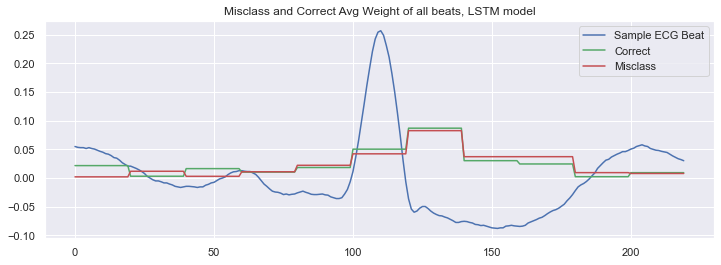

In [20]:
from sklearn.preprocessing import normalize

n0= normalize(final_last_lstm[correct_lstm[:]])
n1= normalize(final_last_lstm[misclass_lstm[:]])
n2= normalize(X_test1[:,:,0,0])

m0=n0.mean(axis=0)
m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='Sample ECG Beat')
plt.plot(np.abs(m0),color='g',label='Correct')
plt.plot(np.abs(m1),color='r',label='Misclass')
# plt.title('Class: N, Number: ' + str(class_num))
# plt.title('Misclass and Correct Avg Weight of F class, LSTM model')
# plt.title('Misclass and Correct Avg Weight of F class on 0.25 std Noise, LSTM model')
plt.title('Misclass and Correct Avg Weight of all beats, LSTM model')
plt.legend()
plt.show()

In [21]:
# saving the model

model_json = lstmmodel.to_json()
with open("lstmmodel_weights.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstmmodel.save_weights("lstmmodel_weights.h5")
lstmmodel.save("lstmmodel.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
#done on GRAD-CAM

from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = np.dot(last_lstm_lstm, softmax_weight_lstm)
new_last_lstm = []

for i in range(len(last_lstm_lstm)):
  means = list(means_of_slices(a[i], 20))
  new_last_lstm.append(means)
new_last_lstm = np.array(new_last_lstm)
print(new_last_lstm.shape)

final_last_lstm = []
for i in new_last_lstm:
  final_last_lstm.append(np.repeat(i,20))
final_last_lstm = np.array(final_last_lstm)
print(final_last_lstm.shape)

(37863, 11)
(37863, 220)


In [23]:
# exp = exp.sort_values(by=['feature'])
# exp_corr = exp_corr.sort_values(by=['feature'])
# exp_mis = exp_mis.sort_values(by=['feature'])

# exp.to_csv('lstm_pfi.csv', encoding='utf-8', index=False)
# exp_corr.to_csv('lstm_pfi_corr.csv', encoding='utf-8', index=False)
# exp_mis.to_csv('lstm_pfi_mis.csv', encoding='utf-8', index=False)

# lstm_pfi = exp.weight.values
# lstm_pfi

In [24]:
# lstm_pfi = pd.read_csv('./drive/MyDrive/compsci/leave_pfi/lstm_pfi.csv')
# # cnn_pfi = pd.read_csv('./drive/MyDrive/compsci/pfi/cnn_pfi.csv')

# lstm_pfi = lstm_pfi.weight.values

In [25]:
# lstm_pfi = normalize(lstm_pfi.reshape(1,-1))
# lstm_pfi = lstm_pfi.ravel()

# lstm_grad_corr = normalize(new_last_lstm[correct_lstm[:]])
# lstm_grad_mis = normalize(new_last_lstm[misclass_lstm[:]])

# lstm_grad_corr = np.abs(lstm_grad_corr)
# lstm_grad_mis = np.abs(lstm_grad_mis)

# corr = pd.DataFrame(lstm_grad_corr)
# df_corr = pd.DataFrame({'mean': corr.mean(), 'median': corr.median(),
#                    '25%': corr.quantile(0.25), '50%': corr.quantile(0.5),
#                    '75%': corr.quantile(0.75)})

# mis = pd.DataFrame(lstm_grad_mis)
# df_mis = pd.DataFrame({'mean': mis.mean(), 'median': mis.median(),
#                    '25%': mis.quantile(0.25), '50%': mis.quantile(0.5),
#                    '75%': mis.quantile(0.75)})

# plt.figure(figsize=(12,3))
# plt.plot(lstm_pfi,color='b',label='PFI')
# plt.plot(df_corr['mean'],color='g',label='Correct Grad-CAM')
# plt.fill_between(np.arange(11), df_corr['25%'], df_corr['75%'], alpha=0.1, facecolor="g")
# plt.plot(df_mis['mean'],color='r',label='Misclass Grad-CAM')
# plt.fill_between(np.arange(11), df_mis['25%'], df_mis['75%'], alpha=0.1, facecolor="r")
# plt.title('Mean and 25%-75% Quartile Per Segment, PFI vs Grad-CAM for / Class on LSTM ')
# plt.xticks(ticks=(0,1,2,3,4,5,6,7,8,9,10))
# plt.legend()
# plt.show()

In [26]:
LSTM_results = pd.DataFrame(data=lstm_results,index=('Model','Accuracy','Precision','Recall','F1score','CM'))
print(LSTM_results)
LSTM_results.to_csv('lstm_results.csv', encoding='utf-8', index=False)

                                                           0
Model                                                   LSTM
Accuracy                                               0.929
Precision                                              0.745
Recall                                                 0.954
F1score                                                0.803
CM         [[26235, 92, 163, 393, 808, 893, 113, 6], [2, ...
